# Best practices for using vision with Claude

Vision allows for a new mode of interaction with Claude. We’ve compiled a few tips for getting the best performance on your images. Before we get to that, let's first setup the code we need to run the notebook.

In [ ]:
%pip install boto3 IPython

In [2]:
import base64
import boto3
import json
from IPython.display import Image

bedrock_rt = boto3.client("bedrock-runtime", region_name="us-east-1")
MODEL_NAME = "claude-3-opus-20240229"

def get_base64_encoded_image(image_path):
    with open(image_path, "rb") as image_file:
        binary_data = image_file.read()
        base_64_encoded_data = base64.b64encode(binary_data)
        base64_string = base_64_encoded_data.decode('utf-8')
        return base64_string

## Applying traditional techniques to multimodal

You can fix hallucination issues with traditional prompt engineering techniques like role assignment. Let’s see an example of this:


Suppose I want Claude to count the number of dogs in this image:

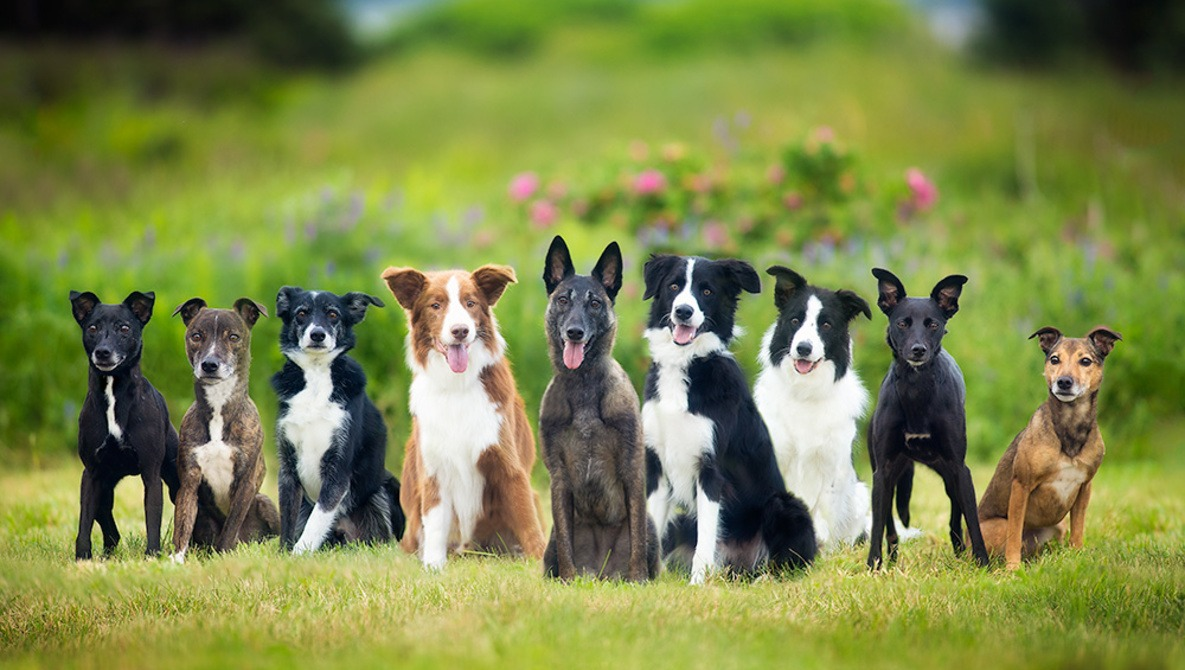

In [3]:
Image(filename='../images/best_practices/nine_dogs.jpg') 

In [4]:
message_list = [
    {
        "role": "user",
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/jpeg", "data": get_base64_encoded_image("../images/best_practices/nine_dogs.jpg")}},
            {"type": "text", "text": "How many dogs are in this picture?"}
        ]
    }
]

prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 2048,
    "messages": message_list
}
body = json.dumps(prompt_config)
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = "application/json"
contentType = "application/json"
response = bedrock_rt.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())
results = response_body.get("content")[0].get("text")
print(results)

The image shows a group of 10 dogs of various breeds sitting together in a grassy field with flowers in the background. The breeds appear to include Border Collies, an Australian Shepherd, and a Terrier mix, though I can't say for certain. The dogs have different colored coats including black, white, brown, and gray. They are all attentively facing the camera, likely posing for the photo.


There's only 9 dogs but Claude thinks there is 10! Let’s apply a little prompt engineering and and try again.

In [5]:
message_list = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "source": {
                    "type": "base64",
                    "media_type": "image/jpeg",
                    "data": get_base64_encoded_image("../images/best_practices/nine_dogs.jpg"),
                },
            },
            {
                "type": "text",
                "text": "You have perfect vision and pay great attention to detail which makes you an expert at counting objects in images. How many dogs are in this picture? Before providing the answer in <answer> tags, think step by step in <thinking> tags and analyze every part of the image.",
            },
        ],
    }
]

prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 2048,
    "messages": message_list,
}
body = json.dumps(prompt_config)
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = "application/json"
contentType = "application/json"
response = bedrock_rt.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())
results = response_body.get("content")[0].get("text")
print(results)

<thinking>
To accurately count the number of dogs in this image, I'll visually scan the image from left to right, focusing on each individual dog.

Starting on the left side, I see two black dogs standing next to each other. Moving to the right, there's a white and gray dog, then a brown and white dog, then a predominantly black dog with white markings.

Continuing to the right, I see a mostly black dog, then a black and white border collie type dog, then another dog with black and white fur.

Scanning the remaining right portion of the image, I see one more brown and white dog.

After carefully examining each dog in the photo, it appears I have accounted for all the dogs present.
</thinking>

<answer>There are 9 dogs total in this image of a diverse group of dogs sitting together in grass with some flowers in the background.</answer>


Great! After applying some prompt engineering to the prompt, we see that Claude now counts correctly that there is 9 dogs.

## Visual prompting 

Images as input allows for prompts to now be given within the image itself. Let’s take a look at some examples.

In this image, we write some text and draw an arrow on it. Let’s just pass this in to Claude with no accompanying text prompt.

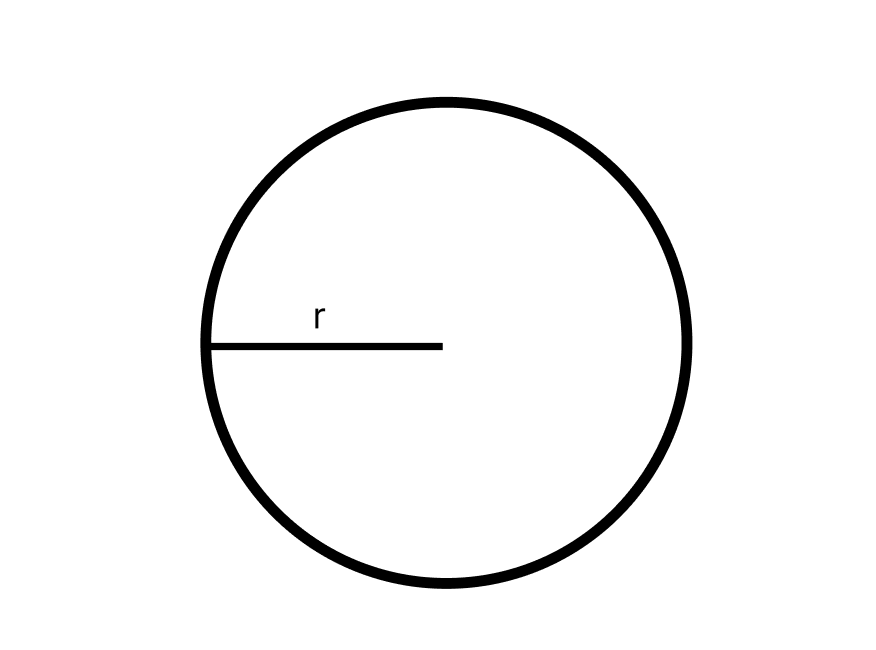

In [6]:
Image(filename='../images/best_practices/circle.png') 

In [7]:
message_list = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "media_type": "image/png",
                "data": get_base64_encoded_image("../images/best_practices/circle.png"),
            }
        ],
    }
]

prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 2048,
    "messages": message_list,
}
body = json.dumps(prompt_config)
modelId = MODEL_NAME
accept = "application/json"
contentType = "application/json"
response = bedrock_rt.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())
results = response_body.get("content")[0].get("text")
print(results)

The image shows a simple black circle outline on a white background. Inside the circle, there is a straight horizontal line segment that does not touch the circle's edges. The circle and line are both drawn with thin, black strokes, giving the appearance of a basic geometric diagram or symbol.


As you can see, Claude tried to describe the image as we didn’t give it a question. Let’s add a question to the image and pass it in again.

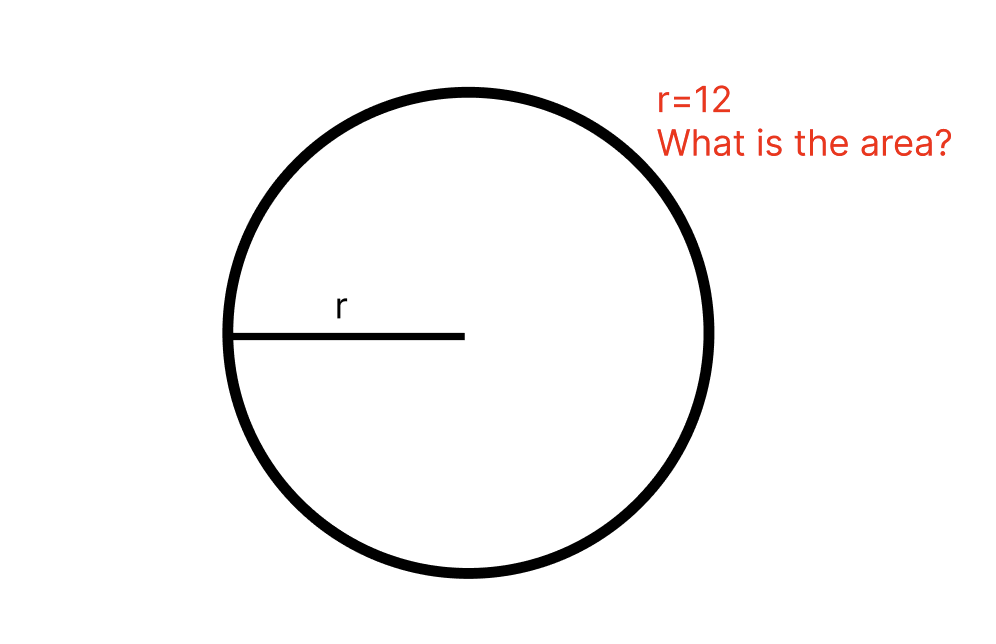

In [8]:
Image(filename='../images/best_practices/labeled_circle.png') 

In [9]:
message_list = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "source": {
                    "type": "base64",
                    "media_type": "image/png",
                    "data": get_base64_encoded_image("../images/best_practices/labeled_circle.png")
                }
            }
        ]
    }
]

prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 2048,
    "messages": message_list
}
body = json.dumps(prompt_config)
modelId = MODEL_NAME
accept = "application/json"
contentType = "application/json"
response = bedrock_rt.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())
results = response_body.get("content")[0].get("text")
print(results)

The area of the circle is πr^2, where r is the radius of the circle. The question states that the radius is 12, so the area would be π(12)^2 = 144π square units.


We can also highlight specific parts of the image and ask questions about it.

What’s the difference between these two numbers?

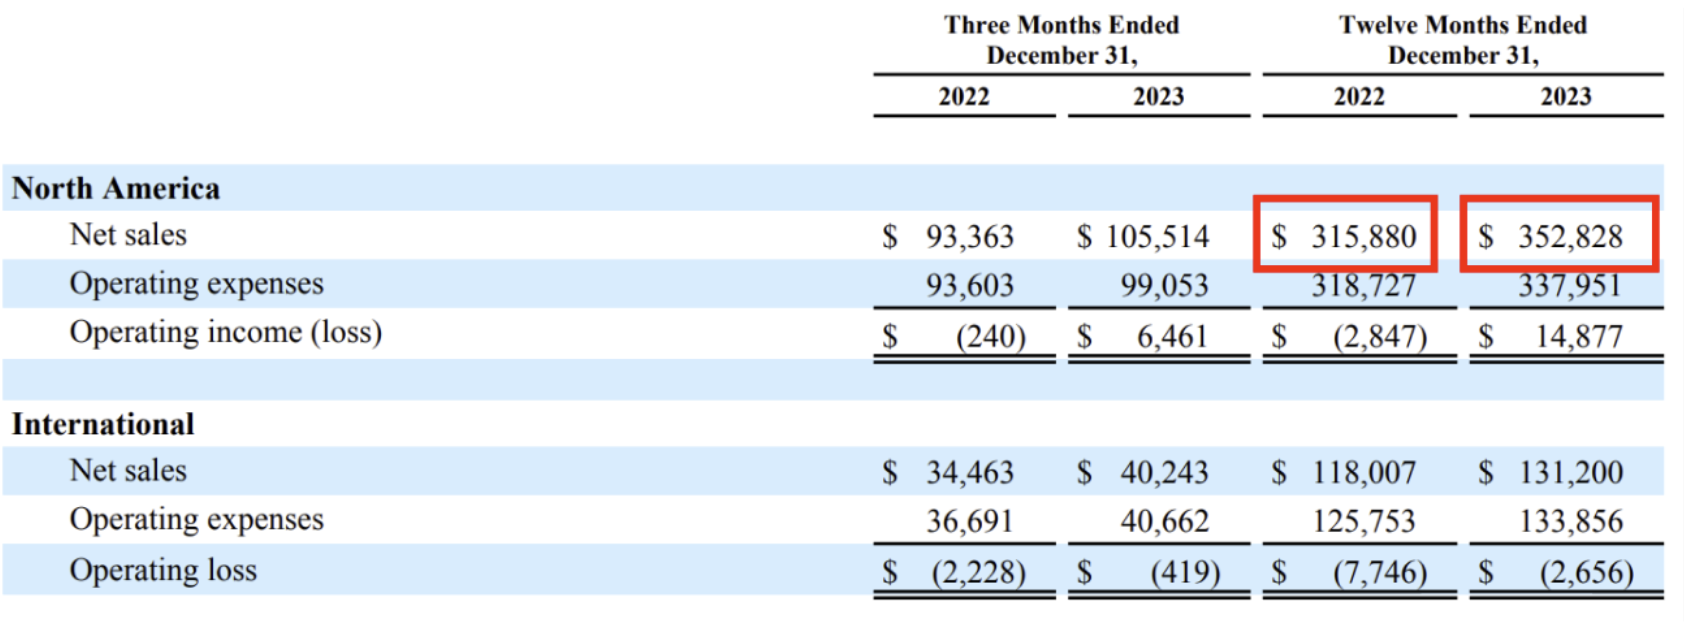

In [10]:
Image(filename='../images/best_practices/table.png') 

In [11]:
message_list = [
    {
        "role": "user",
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("../images/best_practices/table.png")}},
            {"type": "text", "text": "What's the difference between these two numbers?"}
        ]
    }
]

prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 2048,
    "messages": message_list
}
body = json.dumps(prompt_config)
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = "application/json"
contentType = "application/json"
response = bedrock_rt.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())
results = response_body.get("content")[0].get("text")
print(results)

The difference between North America's net sales for the twelve months ended December 31, 2023 ($352,828) and December 31, 2022 ($315,880) is $36,948.


## Few-shot examples

Adding examples to prompts still improves accuracy with visual tasks as well. Let’s ask Claude to read a picture of a speedometer. 

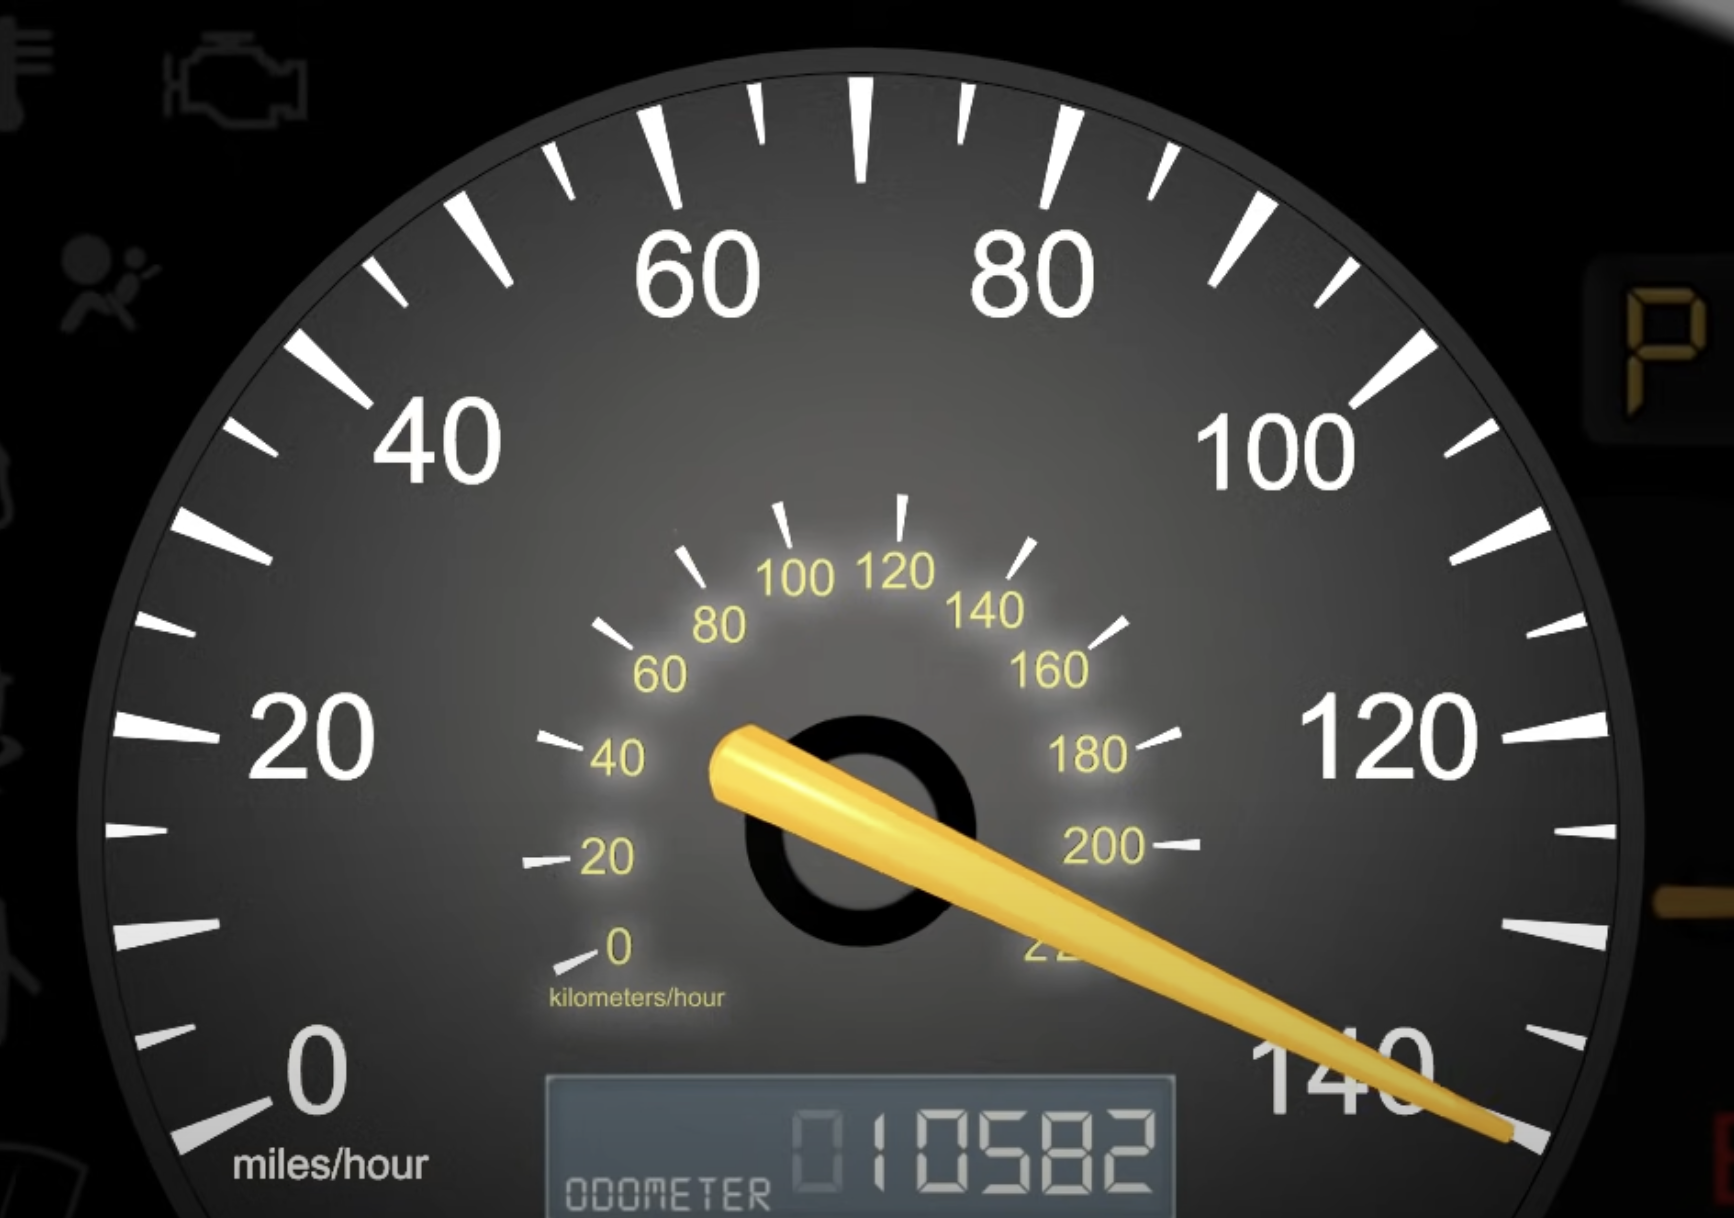

In [22]:
Image(filename='../images/best_practices/140.png') 

In [21]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("../images/best_practices/140.png")}},
            {"type": "text", "text": "What speed am I going?"}
        ]
    }
]

prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 2048,
    "messages": message_list
}
body = json.dumps(prompt_config)
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = "application/json"
contentType = "application/json"
response = bedrock_rt.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())
results = response_body.get("content")[0].get("text")
print(results)

The speedometer in the image is showing a speed of 140 kilometers/hour (or about 87 miles/hour).


Claude’s answer doesn’t look quite right here, it thinks we are going 140km/hour and not 140 miles/hour! Let’s try again but this time let’s add some examples to the prompt.

In [20]:
message_list = [
    {
        "role": "user",
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("../images/best_practices/70.png")}},
            {"type": "text", "text": "What speed am I going?"}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "You are going 70 miles per hour."}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("../images/best_practices/100.png")}},
            {"type": "text", "text": "What speed am I going?"}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "You are going 100 miles per hour."}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("../images/best_practices/140.png")}},
            {"type": "text", "text": "What speed am I going?"}
        ]
    }
]

prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 2048,
    "messages": message_list,
    "temperature": 0
}
body = json.dumps(prompt_config)
modelId = "anthropic.claude-3-opus-20240229-v1:0"
accept = "application/json"
contentType = "application/json"
response = bedrock_rt.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())
results = response_body.get("content")[0].get("text")
print(results)

The speedometer in the image shows that you are going 140 miles per hour.


Perfect! With those examples, Claude learned how to read the speed on the speedometer. Note though that few-shot prompting with images doesn't always work but it is worth trying on your use case.

## Multiple images as input
Claude can also accept and reason over multiple images at once within the prompt as well! For example, let’s say you had a really large image - like an image of a long receipt! We can split that image up into chunks and feed each one of those chunks into Claude.

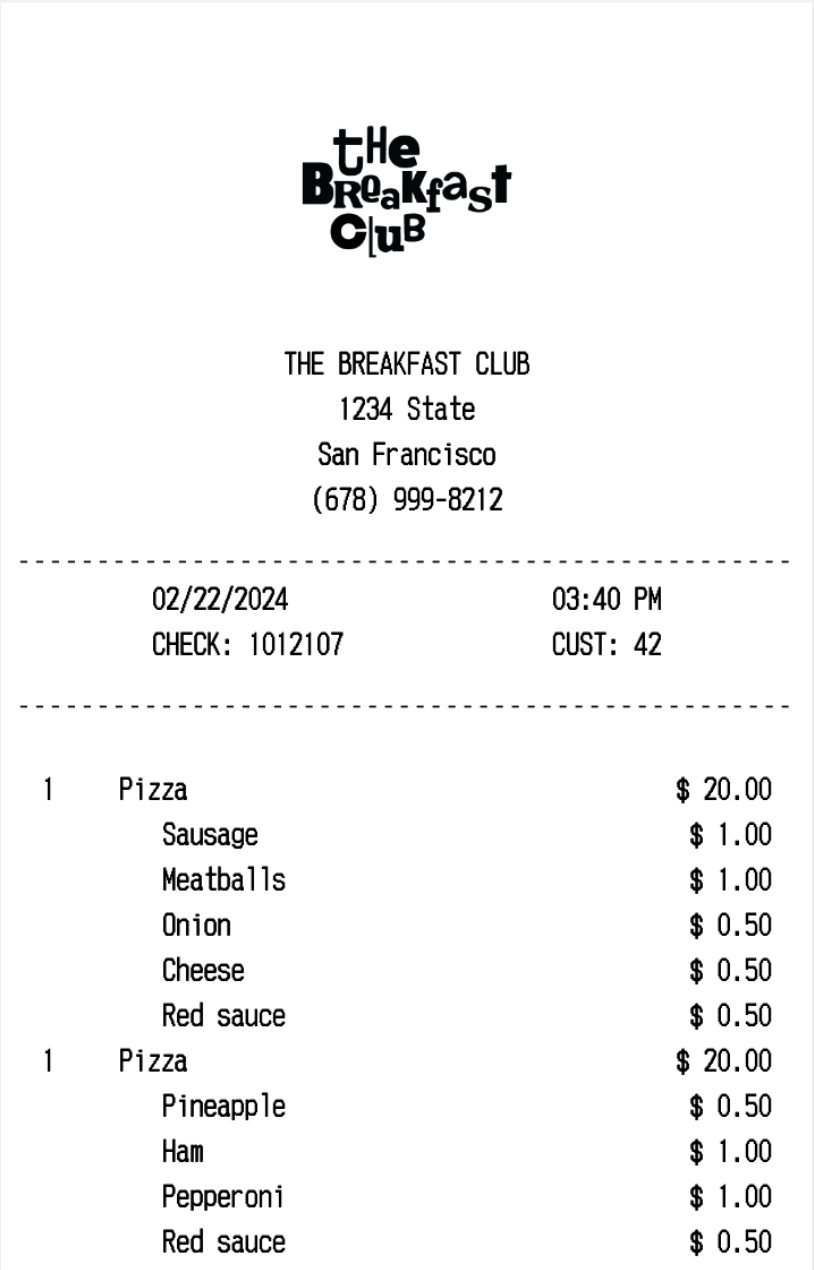

In [23]:
Image(filename='../images/best_practices/receipt1.png') 

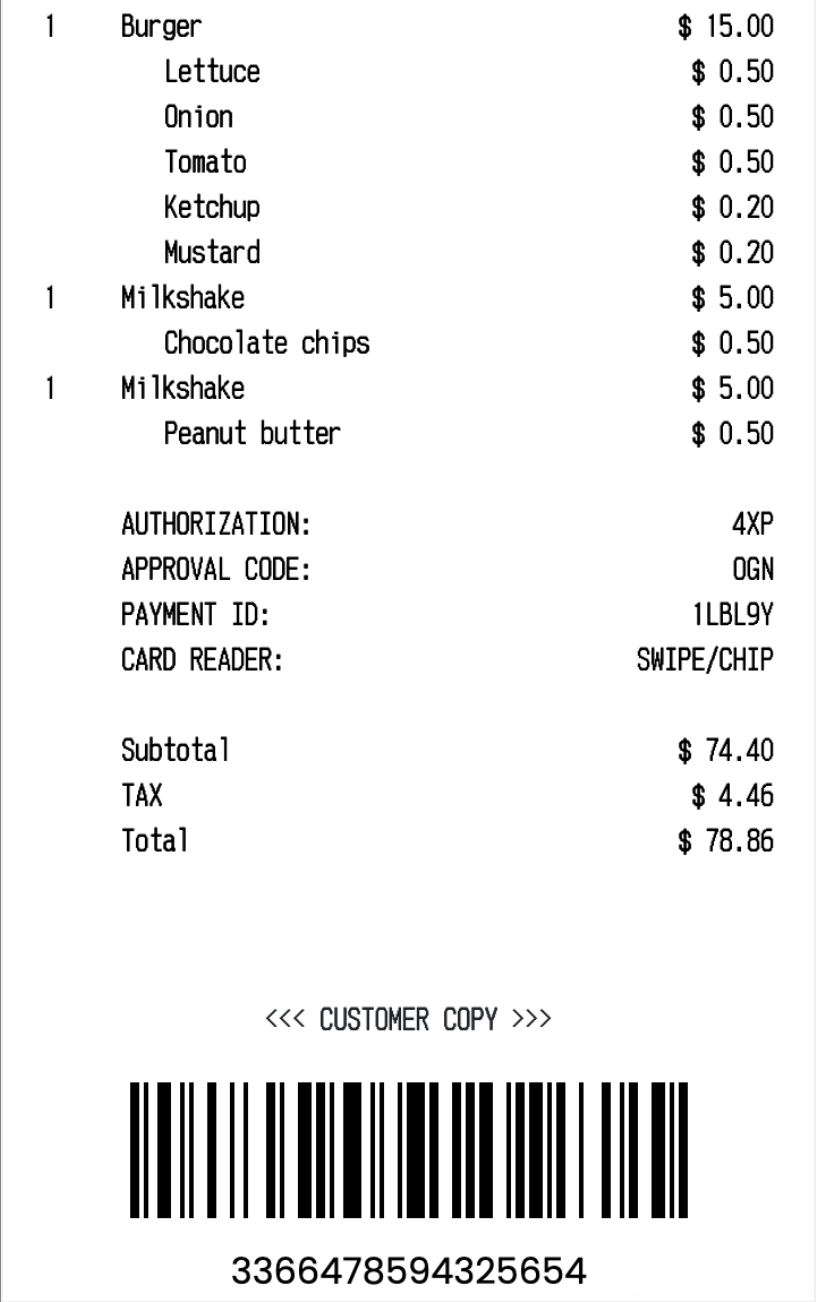

In [24]:
Image(filename='../images/best_practices/receipt2.png') 

In [25]:
message_list = [
    {
        "role": "user",
        "content": [
            {"type": "image", "data": get_base64_encoded_image("../images/best_practices/receipt1.png")},
            {"type": "image", "data": get_base64_encoded_image("../images/best_practices/receipt2.png")},
            {"type": "text", "text": "Output the name of the restaurant and the total."}
        ]
    }
]

prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 2048,
    "messages": message_list
}
body = json.dumps(prompt_config)
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = "application/json"
contentType = "application/json"
response = bedrock_rt.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())
results = response_body.get("content")[0].get("text")
print(results)

The name of the restaurant is The Breakfast Club and the total amount on the receipt is $78.86.


## Object identification from examples

With image input, you can pass in other images to the prompt and Claude will use that information to answer questions. Let’s see an example of this. 

Suppose we were trying to identify the type of pant in an image. We can provide Claude some examples of different types of pants in the prompt.

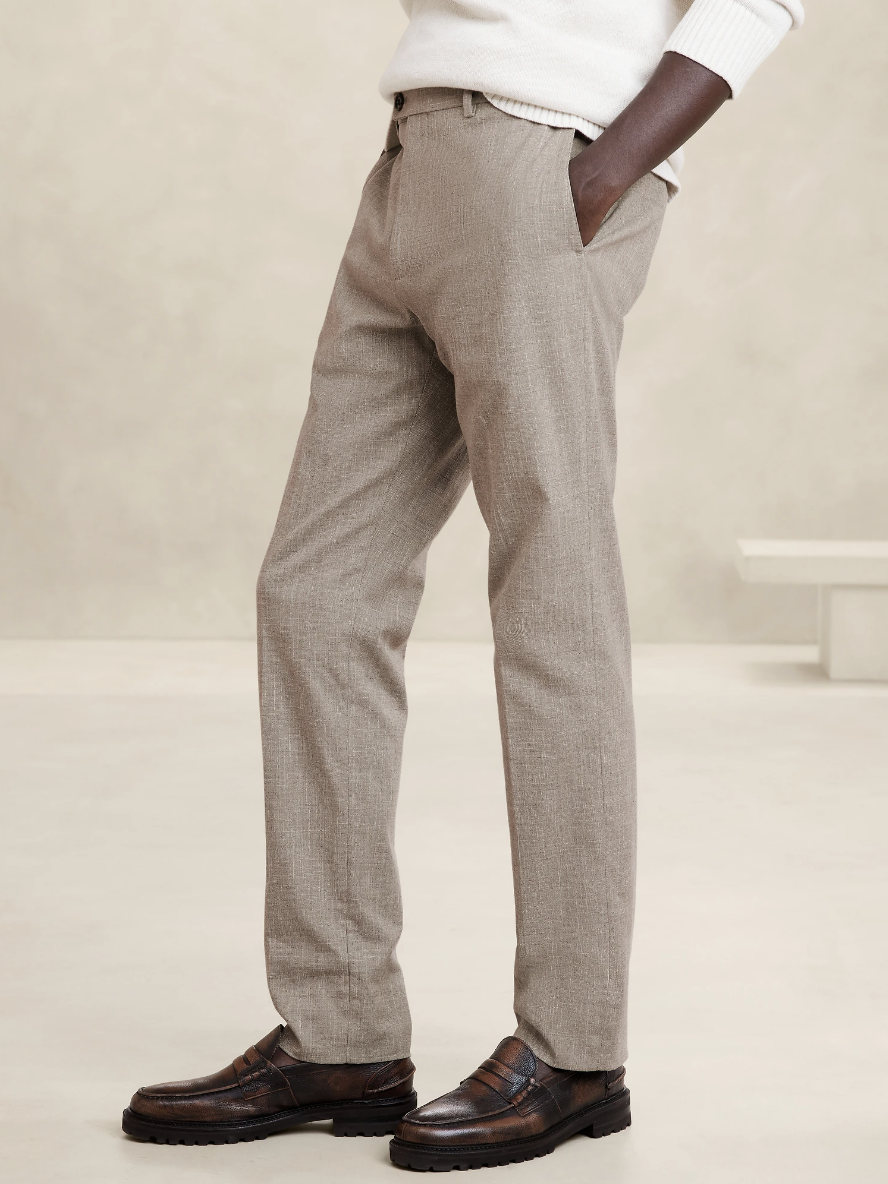

In [26]:
Image(filename='../images/best_practices/officer_example.png') 

In [27]:
message_list = [
    {
        "role": "user",
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("../images/best_practices/wrinkle.png")}},
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("../images/best_practices/officer.png")}},
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("../images/best_practices/chinos.png")}},
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("../images/best_practices/officer_example.png")}},
            {"type": "text", "text": "These pants are (in order) WRINKLE-RESISTANT DRESS PANT, ITALIAN MELTON OFFICER PANT, SLIM RAPID MOVEMENT CHINO. What pant is shown in the last image?"}
        ]
    }
]

prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 2048,
    "messages": message_list
}
body = json.dumps(prompt_config)
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = "application/json"
contentType = "application/json"
response = bedrock_rt.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())
results = response_body.get("content")[0].get("text")
print(results)

The last image shows a person wearing light gray wool dress pants or trousers paired with brown leather dress shoes or loafers. Based on the texture and drape of the fabric, these appear to be the Italian Melton Officer pants that were shown in the second product image.
